In [1]:
from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [3]:
import os
import numpy as np
import pandas as pd
import torch
from multiprocessing import Pool
from sklearn.preprocessing import MinMaxScaler
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import joblib
import os
import numpy as np
import pandas as pd
import torch
from multiprocessing import Pool
from sklearn.preprocessing import MinMaxScaler
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import joblib

SEQUENCE_LENGTH = 600
BATCH_SIZE = 64
EPOCHS = 250
LEARNING_RATE = 1e-5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Load file

In [18]:
# Loading from npz file
data = np.load('/content/gdrive/MyDrive/data600_coolant_qani.npz')



In [39]:

X_original = data['X_original']
y_original = data['y_original']
X_augmented = data['X_augmented']
y_augmented = data['y_augmented']

In [40]:

# Convert data to PyTorch tensors
try:
    X_original = torch.tensor(np.array(X_original), dtype=torch.float32).to(DEVICE)
    y_original = torch.tensor(np.array(y_original), dtype=torch.float32).to(DEVICE)
    X_augmented = torch.tensor(np.array(X_augmented), dtype=torch.float32).to(DEVICE)
    y_augmented = torch.tensor(np.array(y_augmented), dtype=torch.float32).to(DEVICE)
except Exception as e:
    print(f"Error during tensor conversion: {e}")
    print(f"Shapes: X_original - {np.array(X_original).shape}, y_original - {np.array(y_original).shape}")
    print(f"Shapes: X_augmented - {np.array(X_augmented).shape}, y_augmented - {np.array(y_augmented).shape}")
    raise


In [43]:

# Split into training and test sets
# num_test = int(0.2 * len(X_original))
# X_test = X_original[:num_test]
# y_test = y_original[:num_test]
# X_train = torch.cat([X_original[num_test:], X_augmented])
# y_train = torch.cat([y_original[num_test:], y_augmented])


X_train = torch.cat([X_original, X_augmented])
y_train = torch.cat([y_original, y_augmented])
# X_train = X_original[num_test:]
# y_train = y_original[num_test:]


In [44]:
X_train

tensor([[[  4.0000,  56.0000,  -2.5123,   0.0000,  73.0000],
         [  4.0000,  55.0000,  -2.5123,  -1.0000,  73.0000],
         [  4.0000,  54.0000,  -2.5123,  -1.0000,  74.0000],
         ...,
         [  3.0000,  24.0000,  -0.3717,   0.0000,  82.0000],
         [  3.0000,  23.0000,  -0.3717,  -1.0000,  82.0000],
         [  3.0000,  23.0000,  -0.3717,   0.0000,  82.0000]],

        [[  4.0000,  44.0000,  -0.7159,   0.0000,  79.0000],
         [  4.0000,  44.0000,  -0.7159,   0.0000,  79.0000],
         [  4.0000,  45.0000,  -0.7159,   1.0000,  79.0000],
         ...,
         [  1.0000,   0.0000,   0.0000,   0.0000,  79.0000],
         [  1.0000,   0.0000,   0.0000,   0.0000,  79.0000],
         [  1.0000,   0.0000,   0.0000,   0.0000,  79.0000]],

        [[  4.0000,  59.0000,   1.1049,   0.0000,  89.0000],
         [  4.0000,  60.0000,   1.1049,   1.0000,  89.0000],
         [  4.0000,  60.0000,   1.1049,   0.0000,  89.0000],
         ...,
         [  4.0000,  78.0000,   0.2728,

In [45]:
# this cell for delete coolant temp from data
X_train = X_train[:, :, :-1]  # Slicing to exclude the last column

X_train

tensor([[[  4.0000,  56.0000,  -2.5123,   0.0000],
         [  4.0000,  55.0000,  -2.5123,  -1.0000],
         [  4.0000,  54.0000,  -2.5123,  -1.0000],
         ...,
         [  3.0000,  24.0000,  -0.3717,   0.0000],
         [  3.0000,  23.0000,  -0.3717,  -1.0000],
         [  3.0000,  23.0000,  -0.3717,   0.0000]],

        [[  4.0000,  44.0000,  -0.7159,   0.0000],
         [  4.0000,  44.0000,  -0.7159,   0.0000],
         [  4.0000,  45.0000,  -0.7159,   1.0000],
         ...,
         [  1.0000,   0.0000,   0.0000,   0.0000],
         [  1.0000,   0.0000,   0.0000,   0.0000],
         [  1.0000,   0.0000,   0.0000,   0.0000]],

        [[  4.0000,  59.0000,   1.1049,   0.0000],
         [  4.0000,  60.0000,   1.1049,   1.0000],
         [  4.0000,  60.0000,   1.1049,   0.0000],
         ...,
         [  4.0000,  78.0000,   0.2728,  -1.0000],
         [  4.0000,  75.0000,   0.2728,  -3.0000],
         [  4.0000,  74.0000,   0.2728,  -1.0000]],

        ...,

        [[  5.0000, 

In [48]:
X_train1 = X_train.clone()
y_train1 = y_train.clone()

In [49]:
if X_train1.is_cuda:
    X_train1 = X_train1.cpu()

# First, compute min/max along the batch dimension (dim=0)
min_vals = torch.min(X_train1, dim=0).values
max_vals = torch.max(X_train1, dim=0).values

# Then, compute min/max along the sequence length dimension (dim=0)
min_vals = torch.min(min_vals, dim=0).values
max_vals = torch.max(max_vals, dim=0).values

# Print the results
print(f"Min values for each column: {min_vals}")
print(f"Max values for each column: {max_vals}")

Min values for each column: tensor([   0.0000,    0.0000,  -67.5000, -124.0000])
Max values for each column: tensor([  6., 134., 165., 118.])


In [50]:
if y_train1.is_cuda:
    y_train1 = y_train1.cpu()

# First, compute min/max along the batch dimension (dim=0)
min_vals = torch.min(y_train1, dim=0).values
max_vals = torch.max(y_train1, dim=0).values

# Then, compute min/max along the sequence length dimension (dim=0)
min_vals = torch.min(min_vals, dim=0).values
max_vals = torch.max(max_vals, dim=0).values

# Print the results
print(f"Min values for each column: {min_vals}")
print(f"Max values for each column: {max_vals}")

Min values for each column: tensor([-4160.])
Max values for each column: tensor([7339.])


In [26]:
if X_train1.is_cuda:
    X_train1 = X_train1.cpu()

# Compute mean along batch and sequence dimensions (dim=0 and dim=1)
mean_vals = torch.mean(X_train1, dim=(0, 1))
# median_vals = torch.median(X_train1, dim=(0, 1)).values
std_vals = torch.std(X_train1, dim=(0, 1))

# Print the results
print(f"Mean values for each column: {mean_vals}")
# print(f"Median values for each column: {median_vals}")
print(f"Standard deviation for each column: {std_vals}")

Mean values for each column: tensor([0.4381, 0.2561, 0.5011, 0.5003, 0.6080])
Standard deviation for each column: tensor([0.2910, 0.2192, 0.1083, 0.0975, 0.0953])


In [27]:
import matplotlib.pyplot as plt

if X_train1.is_cuda:
    X_train1 = X_train1.cpu()

# Flatten the batch and sequence dimensions to create a 2D tensor (rows: samples, columns: features)
flattened_tensor = X_train1.view(-1, X_train1.size(2)).numpy()



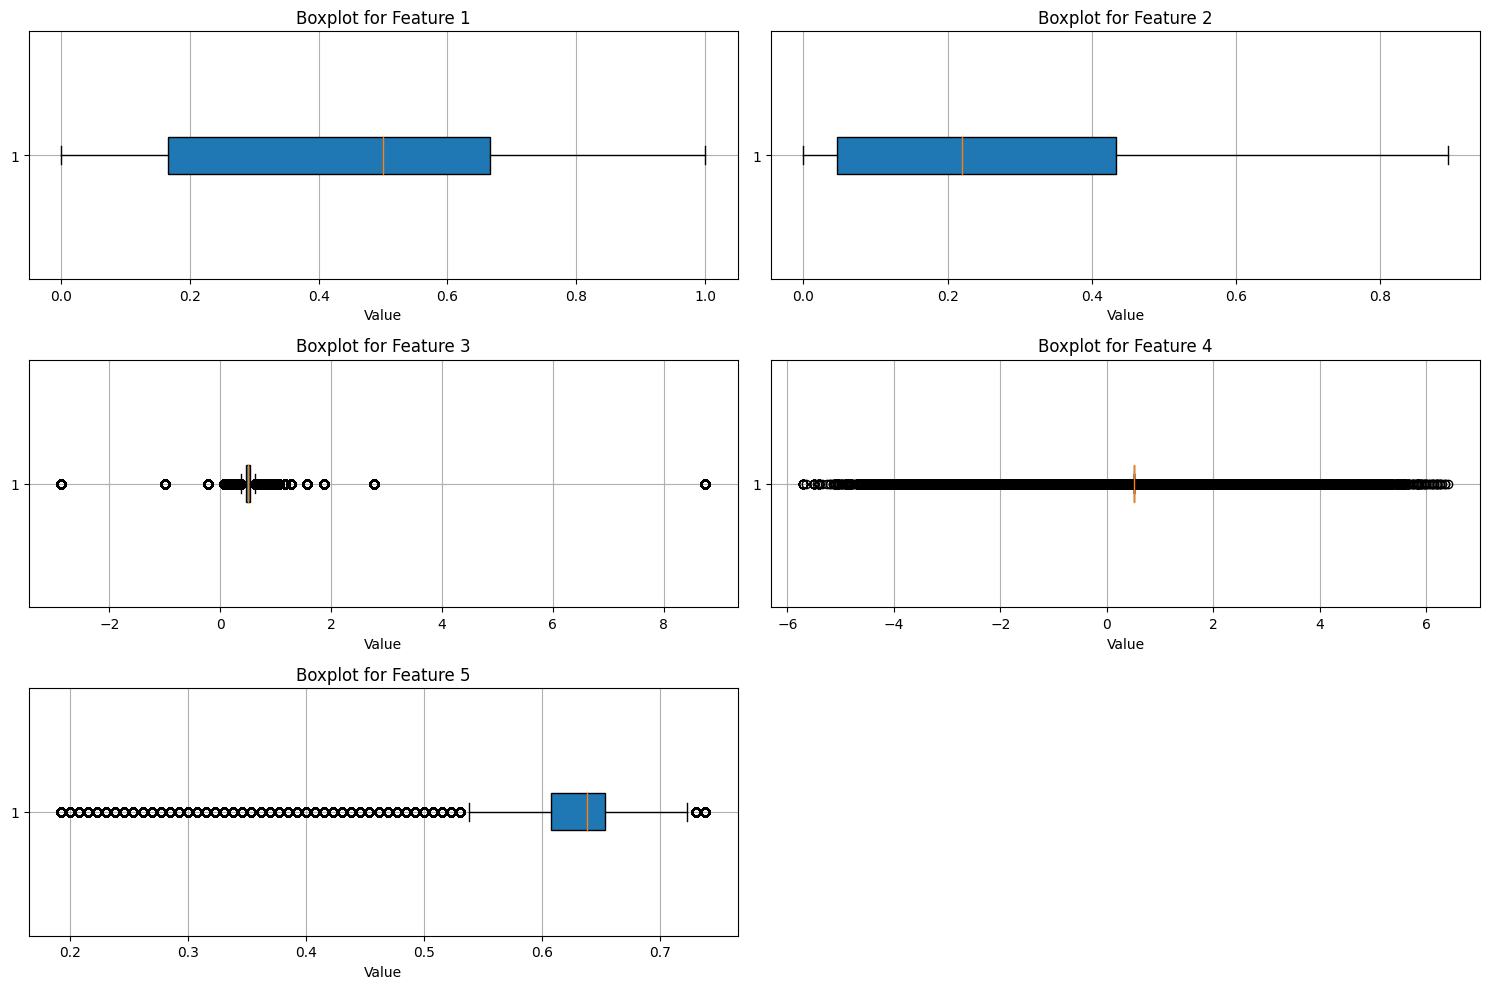

In [28]:
plt.figure(figsize=(15, 10))

num_features = flattened_tensor.shape[1]  # Number of features

# Create a subplot for each feature
for i in range(num_features):
    plt.subplot(3, 2, i+1)
    plt.boxplot(flattened_tensor[:, i], vert=False, patch_artist=True)
    plt.title(f'Boxplot for Feature {i+1}')
    plt.xlabel('Value')
    plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [51]:

# Convert the min and max values to tensors
# min_val_x = torch.tensor([0, 0, -10, -10,0], dtype=torch.float32).to(DEVICE)
# max_val_x = torch.tensor([6, 150, 10, 10,130], dtype=torch.float32).to(DEVICE)

#for without coolant
min_val_x = torch.tensor([0, 0, -10, -10], dtype=torch.float32).to(DEVICE)
max_val_x = torch.tensor([6, 150, 10, 10], dtype=torch.float32).to(DEVICE)


min_val_y = torch.tensor([0], dtype=torch.float32).to(DEVICE)
max_val_y = torch.tensor([10000], dtype=torch.float32).to(DEVICE)

# Custom normalization function for X
def custom_normalize_X(data, min_vals, max_vals):
    for i in range(data.shape[-1]):
        data[:, :, i] = (data[:, :, i] - min_vals[i]) / (max_vals[i] - min_vals[i])
    return data

# Custom normalization function for y
def custom_normalize_y(data, min_val, max_val):
    return (data - min_val) / (max_val - min_val)

# Normalize X_train and X_test
X_train_normalized = custom_normalize_X(X_train, min_val_x, max_val_x)
# X_test_normalized = custom_normalize_X(X_test, min_val_x, max_val_x)

# Normalize y_train and y_test
y_train_normalized = custom_normalize_y(y_train, min_val_y, max_val_y)
# y_test_normalized = custom_normalize_y(y_test, min_val_y, max_val_y)


In [52]:
X_train1 = X_train_normalized.clone()


In [53]:
X_train_normalized

tensor([[[0.6667, 0.3733, 0.3744, 0.5000],
         [0.6667, 0.3667, 0.3744, 0.4500],
         [0.6667, 0.3600, 0.3744, 0.4500],
         ...,
         [0.5000, 0.1600, 0.4814, 0.5000],
         [0.5000, 0.1533, 0.4814, 0.4500],
         [0.5000, 0.1533, 0.4814, 0.5000]],

        [[0.6667, 0.2933, 0.4642, 0.5000],
         [0.6667, 0.2933, 0.4642, 0.5000],
         [0.6667, 0.3000, 0.4642, 0.5500],
         ...,
         [0.1667, 0.0000, 0.5000, 0.5000],
         [0.1667, 0.0000, 0.5000, 0.5000],
         [0.1667, 0.0000, 0.5000, 0.5000]],

        [[0.6667, 0.3933, 0.5552, 0.5000],
         [0.6667, 0.4000, 0.5552, 0.5500],
         [0.6667, 0.4000, 0.5552, 0.5000],
         ...,
         [0.6667, 0.5200, 0.5136, 0.4500],
         [0.6667, 0.5000, 0.5136, 0.3500],
         [0.6667, 0.4933, 0.5136, 0.4500]],

        ...,

        [[0.8333, 0.7467, 0.5460, 0.5000],
         [0.8333, 0.7533, 0.5460, 0.5500],
         [0.8333, 0.7600, 0.5460, 0.5500],
         ...,
         [0.0000, 0.0

In [54]:
import torch.nn as nn
import torch

class FuelConsumptionModel(nn.Module):
    def __init__(self, input_size):
        super(FuelConsumptionModel, self).__init__()
        # LSTM layers
        self.lstm1 = nn.LSTM(input_size, 32, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(64, 32, batch_first=True, bidirectional=True)

        # Layer Normalization after each LSTM
        self.layer_norm1 = nn.LayerNorm(64)
        self.layer_norm2 = nn.LayerNorm(64)

        # Dropout layers
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

        # Dense output layer
        self.dense = nn.Linear(64, 1)

    def forward(self, x):
        # LSTM 1 + Layer Normalization + Dropout
        x, _ = self.lstm1(x)
        x = self.layer_norm1(x)  # Apply layer normalization after LSTM1
        x = self.dropout1(x)

        # LSTM 2 + Layer Normalization + Dropout
        x, _ = self.lstm2(x)
        x = self.layer_norm2(x)  # Apply layer normalization after LSTM2
        x = self.dropout2(x)

        # Dense layer for final output
        x = self.dense(x)

        return x


In [31]:
X_train_normalized.shape[-1]

5

In [55]:

# Instantiate the model, define the loss function and the optimizer
model = FuelConsumptionModel(input_size=X_train_normalized.shape[-1]).to(DEVICE)
criterion = nn.L1Loss()
weight_decay = 1e-6  # L2 regularization factor
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=weight_decay)

In [56]:
# Assume 80% of the data is used for training and 20% for validation
train_size = int(0.8 * len(X_train_normalized))
val_size = len(X_train_normalized) - train_size

# Split the data while preserving the order
X_train_split = X_train_normalized[:train_size]
y_train_split = y_train_normalized[:train_size]

X_val_split = X_train_normalized[train_size:]
y_val_split = y_train_normalized[train_size:]



# BATCH_SIZE = 96
# # Create DataLoader for training and validation sets
# train_loader = DataLoader(TensorDataset(X_train_split, y_train_split), batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(TensorDataset(X_val_split, y_val_split), batch_size=BATCH_SIZE, shuffle=False)




In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR  # Importing StepLR for learning rate decay
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Assuming `FuelConsumptionModel`, `X_train_normalized`, `train_loader`, `val_loader`, `DEVICE`, and `EPOCHS` are defined

# Choose a single loss function to use for all experiments
criterion = nn.L1Loss()  # You can change this to your preferred loss function

EPOCHS = 500
# Define weight decay values and initial learning rates for decay schedules
weight_decay_values = 1e-6
initial_learning_rates = [1e-4]  # Two starting learning rates

# Initialize variables to track the best parameters
best_weight_decay = None
best_initial_lr = None
best_model_weights = None
best_val_loss = float('inf')

ini_batches = [64]
# Loop over all combinations of initial learning rates and weight decay values

BATCH_SIZE = 64
# Create DataLoader for training and validation sets
train_loader = DataLoader(TensorDataset(X_train_split, y_train_split), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_split, y_val_split), batch_size=BATCH_SIZE, shuffle=False)

for init_lr in initial_learning_rates:
    # Initialize model, criterion, and optimizer for each combination
    model = FuelConsumptionModel(input_size=X_train_normalized.shape[-1]).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=weight_decay_values)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    # Early stopping parameters
    patience = 20  # Number of epochs to wait before stopping if no improvement
    best_loss = float('inf')  # Initialize best loss to infinity
    epochs_without_improvement = 0  # Counter for epochs without improvement

    # Training loop with early stopping
    model.train()
    for epoch in range(EPOCHS):
        running_loss = 0.0
        model.train()  # Ensure model is in training mode

        # Training phase
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)  # Ensure data is on the correct device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate average loss for the epoch
        avg_training_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()  # Switch to evaluation mode
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:  # Assume you have a validation DataLoader `val_loader`
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)  # Ensure data is on the correct device
                outputs = model(inputs)
                val_loss = criterion(outputs, targets)
                val_running_loss += val_loss.item()

        avg_val_loss = val_running_loss / len(val_loader)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1}/{EPOCHS}] ---- Training Loss: {avg_training_loss:.4f} ---- Validation Loss: {avg_val_loss:.6f} ------{current_lr}")

        # print(f"Epoch [{epoch+1}/{EPOCHS}] ---- Training Loss: {avg_training_loss:.4f} ---- Validation Loss: {avg_val_loss:.4f}    Init LR: {init_lr:.0e}  WD: {wd:.0e}")

        # Adjust the learning rate
        scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Save the model for the current combination
        model_filename = f'best_fuel_consumption_model.pth'
        torch.save(model.state_dict(), model_filename)


print(f"Saved model: {model_filename}")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/500] ---- Training Loss: 0.0777 ---- Validation Loss: 0.028765 ------0.0001
Epoch [2/500] ---- Training Loss: 0.0308 ---- Validation Loss: 0.026708 ------0.0001
Epoch [3/500] ---- Training Loss: 0.0267 ---- Validation Loss: 0.022175 ------0.0001
Epoch [4/500] ---- Training Loss: 0.0230 ---- Validation Loss: 0.019277 ------0.0001
Epoch [5/500] ---- Training Loss: 0.0205 ---- Validation Loss: 0.017232 ------0.0001
Epoch [6/500] ---- Training Loss: 0.0186 ---- Validation Loss: 0.015893 ------0.0001
Epoch [7/500] ---- Training Loss: 0.0175 ---- Validation Loss: 0.015313 ------0.0001
Epoch [8/500] ---- Training Loss: 0.0168 ---- Validation Loss: 0.014842 ------0.0001
Epoch [9/500] ---- Training Loss: 0.0163 ---- Validation Loss: 0.014692 ------0.0001
Epoch [10/500] ---- Training Loss: 0.0159 ---- Validation Loss: 0.014388 ------0.0001
Epoch [11/500] ---- Training Loss: 0.0156 ---- Validation Loss: 0.014256 ------0.0001
Epoch [12/500] ---- Training Loss: 0.0153 ---- Validation Loss:

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR  # Importing StepLR for learning rate decay
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Assuming `FuelConsumptionModel`, `X_train_normalized`, `train_loader`, `val_loader`, `DEVICE`, and `EPOCHS` are defined

# Choose a single loss function to use for all experiments
criterion = nn.L1Loss()  # You can change this to your preferred loss function

EPOCHS = 500
# Define weight decay values and initial learning rates for decay schedules
weight_decay_values = 1e-6
initial_learning_rates = [1e-4]  # Two starting learning rates

# Initialize variables to track the best parameters
best_weight_decay = None
best_initial_lr = None
best_model_weights = None
best_val_loss = float('inf')

ini_batches = [64]
# Loop over all combinations of initial learning rates and weight decay values

BATCH_SIZE = 64
# Create DataLoader for training and validation sets
train_loader = DataLoader(TensorDataset(X_train_split, y_train_split), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_split, y_val_split), batch_size=BATCH_SIZE, shuffle=False)

for init_lr in initial_learning_rates:
    # Initialize model, criterion, and optimizer for each combination
    model = FuelConsumptionModel(input_size=X_train_normalized.shape[-1]).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=weight_decay_values)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    # Early stopping parameters
    patience = 20  # Number of epochs to wait before stopping if no improvement
    best_loss = float('inf')  # Initialize best loss to infinity
    epochs_without_improvement = 0  # Counter for epochs without improvement

    # Training loop with early stopping
    model.train()
    for epoch in range(EPOCHS):
        running_loss = 0.0
        model.train()  # Ensure model is in training mode

        # Training phase
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)  # Ensure data is on the correct device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate average loss for the epoch
        avg_training_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()  # Switch to evaluation mode
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:  # Assume you have a validation DataLoader `val_loader`
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)  # Ensure data is on the correct device
                outputs = model(inputs)
                val_loss = criterion(outputs, targets)
                val_running_loss += val_loss.item()

        avg_val_loss = val_running_loss / len(val_loader)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1}/{EPOCHS}] ---- Training Loss: {avg_training_loss:.4f} ---- Validation Loss: {avg_val_loss:.6f} ------{current_lr}")

        # print(f"Epoch [{epoch+1}/{EPOCHS}] ---- Training Loss: {avg_training_loss:.4f} ---- Validation Loss: {avg_val_loss:.4f}    Init LR: {init_lr:.0e}  WD: {wd:.0e}")

        # Adjust the learning rate
        scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Save the model for the current combination
        model_filename = f'mode_without_coolant_qani.pth'
        torch.save(model.state_dict(), model_filename)


print(f"Saved model: {model_filename}")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/500] ---- Training Loss: 0.0782 ---- Validation Loss: 0.027671 ------0.0001
Epoch [2/500] ---- Training Loss: 0.0281 ---- Validation Loss: 0.023100 ------0.0001
Epoch [3/500] ---- Training Loss: 0.0233 ---- Validation Loss: 0.019051 ------0.0001
Epoch [4/500] ---- Training Loss: 0.0201 ---- Validation Loss: 0.016721 ------0.0001
Epoch [5/500] ---- Training Loss: 0.0182 ---- Validation Loss: 0.015666 ------0.0001
Epoch [6/500] ---- Training Loss: 0.0172 ---- Validation Loss: 0.015233 ------0.0001
Epoch [7/500] ---- Training Loss: 0.0166 ---- Validation Loss: 0.014904 ------0.0001
Epoch [8/500] ---- Training Loss: 0.0161 ---- Validation Loss: 0.014731 ------0.0001
Epoch [9/500] ---- Training Loss: 0.0158 ---- Validation Loss: 0.014515 ------0.0001
Epoch [10/500] ---- Training Loss: 0.0155 ---- Validation Loss: 0.014424 ------0.0001
Epoch [11/500] ---- Training Loss: 0.0153 ---- Validation Loss: 0.014314 ------0.0001
Epoch [12/500] ---- Training Loss: 0.0151 ---- Validation Loss:

#test

#Test with all saved model


In [1]:
import torch.nn as nn
import torch

class FuelConsumptionModel(nn.Module):
    def __init__(self, input_size):
        super(FuelConsumptionModel, self).__init__()
        # LSTM layers
        self.lstm1 = nn.LSTM(input_size, 32, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(64, 32, batch_first=True, bidirectional=True)

        # Layer Normalization after each LSTM
        self.layer_norm1 = nn.LayerNorm(64)
        self.layer_norm2 = nn.LayerNorm(64)

        # Dropout layers
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

        # Dense output layer
        self.dense = nn.Linear(64, 1)

    def forward(self, x):
        # LSTM 1 + Layer Normalization + Dropout
        x, _ = self.lstm1(x)
        x = self.layer_norm1(x)  # Apply layer normalization after LSTM1
        x = self.dropout1(x)

        # LSTM 2 + Layer Normalization + Dropout
        x, _ = self.lstm2(x)
        x = self.layer_norm2(x)  # Apply layer normalization after LSTM2
        x = self.dropout2(x)

        # Dense layer for final output
        x = self.dense(x)

        return x


In [2]:
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn as nn
import torch

# Constants
SEQUENCE_LENGTH = 600  # Updated sequence length
PLOT_SAVE_DIR = 'predicted_vs_actual_plots'  # Base directory to save plots and CSVs
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure the base save directory exists
os.makedirs(PLOT_SAVE_DIR, exist_ok=True)

# Define the PyTorch model structure (same as the one used for training)


# Load the trained model
def load_trained_model(model_path, input_size):
    model = FuelConsumptionModel(input_size=input_size)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    return model

# Process the file and prepare segments
def process_file(file_path):
    df = pd.read_csv(file_path)
    # df = df.iloc[::2].reset_index(drop=True)
    df['Time'] = df['time'] - df['time'].iloc[0]
    df['Trip fuel consumption'] = df['Trip_fuel_consumption'] - df['Trip_fuel_consumption'].iloc[0]
    df['Acceleration'] = df['Vehicle_Speed'].diff().fillna(0)
    df['Momentary fuel consumption'] = df['Trip fuel consumption'].diff().fillna(0)

    df['Adjusted_gear_position'] = df['Current_gear_shift_position_(Current_gear)'].replace({13: 0, 14: 1})

    # Selecting features and target
    features = df[['Adjusted_gear_position', 'Vehicle_Speed', 'slope', 'Acceleration','Coolant_temperature']]
    target = df['Momentary fuel consumption']
    target = df['Momentary fuel consumption']
    return features, target

# Pad and normalize the data
def pad_and_normalize(data, sequence_length=SEQUENCE_LENGTH):
    padded_data = np.zeros((len(data), sequence_length, data[0].shape[1]))
    for i, seq in enumerate(data):
        length = min(len(seq), sequence_length)
        padded_data[i, :length] = seq[:length]

    # Normalization (same as in your script)
    min_val_x = [0, 0, -10, -10,0]
    max_val_x = [6, 150, 10, 10,130]
    for i in range(padded_data.shape[-1]):
        padded_data[:, :, i] = (padded_data[:, :, i] - min_val_x[i]) / (max_val_x[i] - min_val_x[i])

    return torch.tensor(padded_data, dtype=torch.float32).to(DEVICE)


# Predict and plot the results
def plot_predicted_vs_real(input_file, model, model_name):
    features, actual_values = process_file(input_file)
    num_segments = len(features) // SEQUENCE_LENGTH
    predictions = []

    for i in range(num_segments):
        segment = features.iloc[i * SEQUENCE_LENGTH:(i + 1) * SEQUENCE_LENGTH]
        segment_normalized = pad_and_normalize([segment.values])
        with torch.no_grad():
            segment_predictions = model(segment_normalized).cpu().numpy()
        predictions.extend(segment_predictions.flatten() * 10000)

    # Handle any remaining data
    remainder = len(features) % SEQUENCE_LENGTH
    if remainder != 0:
        last_segment = features.iloc[-remainder:]
        last_segment_normalized = pad_and_normalize([last_segment.values], sequence_length=remainder)
        with torch.no_grad():
            last_segment_predictions = model(last_segment_normalized).cpu().numpy()
        predictions.extend(last_segment_predictions.flatten() * 10000)

    predictions = np.array(predictions)
    actual_valuess = actual_values.values[:len(predictions)]  # Ensure lengths match

    # Calculate error metrics
    mae = mean_absolute_error(actual_valuess, predictions)
    mse = mean_squared_error(actual_valuess, predictions)
    mape = np.mean(np.abs((actual_valuess - predictions) / actual_valuess)) * 100

    print(f'MAE: {mae:.4f}---------------{input_file}')
    print(f'MSE: {mse:.4f}')
    print(f'MAPE: {mape:.4f}% ---------------------')

    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(actual_values.values[:len(predictions)], axis=0), label='Real', color='blue')
    plt.plot(np.cumsum(predictions[:len(actual_values)], axis=0), label='Predicted', color='red')
    plt.xlabel('Index')
    plt.ylabel('Fuel Consumption')
    plt.title(f'Predicted vs Real Fuel Consumption ({model_name})')
    plt.legend()

    # Create model-specific directory
    model_save_dir = os.path.join(PLOT_SAVE_DIR, model_name)
    os.makedirs(model_save_dir, exist_ok=True)

    # Save plot using model name in the designated directory
    plot_filename = os.path.join(model_save_dir, f'{os.path.splitext(os.path.basename(input_file))[0]}_all.png')
    plt.savefig(plot_filename)
    plt.close()

    # print(f"Plot saved as: {plot_filename}")

    # Save predictions and actual values to CSV using model name in the designated directory
    results_df = pd.DataFrame({
        'Speed': features["Vehicle_Speed"].iloc[:len(predictions)],
        'Actual': np.cumsum(actual_values.values[:len(predictions)], axis=0),
        'Predicted': np.cumsum(predictions[:len(actual_values)], axis=0)
    })

    csv_filename = os.path.join(model_save_dir, f'{os.path.splitext(os.path.basename(input_file))[0]}.csv')
    results_df.to_csv(csv_filename, index=False)
    print(f"CSV saved as: {csv_filename}")
# Directory containing all saved models and CSV files
csv_dir = '/content/'  # Directory containing CSV files
model_dir = '/content/'  # Directory containing model files

# List all model files in the directory
model_files = [f for f in os.listdir(model_dir) if f.endswith('.pth')]

# List all CSV files in the directory
csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]

# Load and test each model on each CSV file
input_size = 5  # Number of features in the input data

for csv_file in csv_files:
    csv_file_path = os.path.join(csv_dir, csv_file)
    # print(f"Processing CSV file: {csv_file}")

    for model_file in model_files:
        model_path = os.path.join(model_dir, model_file)
        model_name = os.path.splitext(model_file)[0]  # Get the base name of the model file
        # print(f"Testing model: {model_name} on {csv_file}")

        model = load_trained_model(model_path, input_size)
        plot_predicted_vs_real(csv_file_path, model, model_name)


<ipython-input-2-6bf83f3f288e>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))
<ipython-input-2-6bf83f3f

MAE: 107.4431---------------/content/Trip_6.csv
MSE: 24035.0260
MAPE: inf% ---------------------
CSV saved as: predicted_vs_actual_plots/mode_with_coolant_qani/Trip_6.csv
MAE: 91.4855---------------/content/Trip_14.csv
MSE: 20476.4109
MAPE: inf% ---------------------


<ipython-input-2-6bf83f3f288e>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))
<ipython-input-2-6bf83f3f

CSV saved as: predicted_vs_actual_plots/mode_with_coolant_qani/Trip_14.csv
MAE: 111.0307---------------/content/Trip_1.csv
MSE: 26631.6066
MAPE: inf% ---------------------


<ipython-input-2-6bf83f3f288e>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))
<ipython-input-2-6bf83f3f

CSV saved as: predicted_vs_actual_plots/mode_with_coolant_qani/Trip_1.csv
MAE: 118.0829---------------/content/Trip_11.csv
MSE: 30090.9000
MAPE: inf% ---------------------


<ipython-input-2-6bf83f3f288e>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))
<ipython-input-2-6bf83f3f

CSV saved as: predicted_vs_actual_plots/mode_with_coolant_qani/Trip_11.csv
MAE: 117.6621---------------/content/Trip_10.csv
MSE: 29220.7950
MAPE: inf% ---------------------


<ipython-input-2-6bf83f3f288e>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))
<ipython-input-2-6bf83f3f

CSV saved as: predicted_vs_actual_plots/mode_with_coolant_qani/Trip_10.csv
MAE: 110.4022---------------/content/Trip_9.csv
MSE: 27427.8901
MAPE: inf% ---------------------


<ipython-input-2-6bf83f3f288e>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))
<ipython-input-2-6bf83f3f

CSV saved as: predicted_vs_actual_plots/mode_with_coolant_qani/Trip_9.csv
MAE: 108.3515---------------/content/Trip_7.csv
MSE: 27836.7076
MAPE: inf% ---------------------


<ipython-input-2-6bf83f3f288e>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))
<ipython-input-2-6bf83f3f

CSV saved as: predicted_vs_actual_plots/mode_with_coolant_qani/Trip_7.csv


In [4]:
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn as nn
import torch

# Constants
SEQUENCE_LENGTH = 600  # Updated sequence length
PLOT_SAVE_DIR = 'predicted_vs_actual_plots'  # Base directory to save plots and CSVs
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure the base save directory exists
os.makedirs(PLOT_SAVE_DIR, exist_ok=True)

# Define the PyTorch model structure (same as the one used for training)


# Load the trained model
def load_trained_model(model_path, input_size):
    model = FuelConsumptionModel(input_size=input_size)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    return model

# Process the file and prepare segments
def process_file(file_path):
    df = pd.read_csv(file_path)
    # df = df.iloc[::2].reset_index(drop=True)
    df['Time'] = df['time'] - df['time'].iloc[0]
    df['Trip fuel consumption'] = df['Trip_fuel_consumption'] - df['Trip_fuel_consumption'].iloc[0]
    df['Acceleration'] = df['Vehicle_Speed'].diff().fillna(0)
    df['Momentary fuel consumption'] = df['Trip fuel consumption'].diff().fillna(0)

    df['Adjusted_gear_position'] = df['Current_gear_shift_position_(Current_gear)'].replace({13: 0, 14: 1})

    # Selecting features and target
    features = df[['Adjusted_gear_position', 'Vehicle_Speed', 'slope', 'Acceleration']]
    target = df['Momentary fuel consumption']
    target = df['Momentary fuel consumption']
    return features, target

# Pad and normalize the data
def pad_and_normalize(data, sequence_length=SEQUENCE_LENGTH):
    padded_data = np.zeros((len(data), sequence_length, data[0].shape[1]))
    for i, seq in enumerate(data):
        length = min(len(seq), sequence_length)
        padded_data[i, :length] = seq[:length]

    # Normalization (same as in your script)
    min_val_x = [0, 0, -10, -10]
    max_val_x = [6, 150, 10, 10]
    for i in range(padded_data.shape[-1]):
        padded_data[:, :, i] = (padded_data[:, :, i] - min_val_x[i]) / (max_val_x[i] - min_val_x[i])

    return torch.tensor(padded_data, dtype=torch.float32).to(DEVICE)


# Predict and plot the results
def plot_predicted_vs_real(input_file, model, model_name):
    features, actual_values = process_file(input_file)
    num_segments = len(features) // SEQUENCE_LENGTH
    predictions = []

    for i in range(num_segments):
        segment = features.iloc[i * SEQUENCE_LENGTH:(i + 1) * SEQUENCE_LENGTH]
        segment_normalized = pad_and_normalize([segment.values])
        with torch.no_grad():
            segment_predictions = model(segment_normalized).cpu().numpy()
        predictions.extend(segment_predictions.flatten() * 10000)

    # Handle any remaining data
    remainder = len(features) % SEQUENCE_LENGTH
    if remainder != 0:
        last_segment = features.iloc[-remainder:]
        last_segment_normalized = pad_and_normalize([last_segment.values], sequence_length=remainder)
        with torch.no_grad():
            last_segment_predictions = model(last_segment_normalized).cpu().numpy()
        predictions.extend(last_segment_predictions.flatten() * 10000)

    predictions = np.array(predictions)
    actual_valuess = actual_values.values[:len(predictions)]  # Ensure lengths match

    # Calculate error metrics
    mae = mean_absolute_error(actual_valuess, predictions)
    mse = mean_squared_error(actual_valuess, predictions)
    mape = np.mean(np.abs((actual_valuess - predictions) / actual_valuess)) * 100

    print(f'MAE: {mae:.4f}---------------{input_file}')
    print(f'MSE: {mse:.4f}')
    print(f'MAPE: {mape:.4f}% ---------------------')

    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(actual_values.values[:len(predictions)], axis=0), label='Real', color='blue')
    plt.plot(np.cumsum(predictions[:len(actual_values)], axis=0), label='Predicted', color='red')
    plt.xlabel('Index')
    plt.ylabel('Fuel Consumption')
    plt.title(f'Predicted vs Real Fuel Consumption ({model_name})')
    plt.legend()

    # Create model-specific directory
    model_save_dir = os.path.join(PLOT_SAVE_DIR, model_name)
    os.makedirs(model_save_dir, exist_ok=True)

    # Save plot using model name in the designated directory
    plot_filename = os.path.join(model_save_dir, f'{os.path.splitext(os.path.basename(input_file))[0]}_all.png')
    plt.savefig(plot_filename)
    plt.close()

    # print(f"Plot saved as: {plot_filename}")

    # Save predictions and actual values to CSV using model name in the designated directory
    results_df = pd.DataFrame({
        'Speed': features["Vehicle_Speed"].iloc[:len(predictions)],
        'Actual': np.cumsum(actual_values.values[:len(predictions)], axis=0),
        'Predicted': np.cumsum(predictions[:len(actual_values)], axis=0)
    })

    csv_filename = os.path.join(model_save_dir, f'{os.path.splitext(os.path.basename(input_file))[0]}.csv')
    results_df.to_csv(csv_filename, index=False)
    print(f"CSV saved as: {csv_filename}")
# Directory containing all saved models and CSV files
csv_dir = '/content/'  # Directory containing CSV files
model_dir = '/content/sample_data'  # Directory containing model files

# List all model files in the directory
model_files = [f for f in os.listdir(model_dir) if f.endswith('.pth')]

# List all CSV files in the directory
csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]

# Load and test each model on each CSV file
input_size = 4  # Number of features in the input data

for csv_file in csv_files:
    csv_file_path = os.path.join(csv_dir, csv_file)
    # print(f"Processing CSV file: {csv_file}")

    for model_file in model_files:
        model_path = os.path.join(model_dir, model_file)
        model_name = os.path.splitext(model_file)[0]  # Get the base name of the model file
        # print(f"Testing model: {model_name} on {csv_file}")

        model = load_trained_model(model_path, input_size)
        plot_predicted_vs_real(csv_file_path, model, model_name)


<ipython-input-4-182cf7f1c968>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))
<ipython-input-4-182cf7f1

MAE: 113.0766---------------/content/Trip_6.csv
MSE: 35633.3350
MAPE: inf% ---------------------
CSV saved as: predicted_vs_actual_plots/mode_without_coolant_qani/Trip_6.csv
MAE: 83.1384---------------/content/Trip_14.csv
MSE: 18288.2864
MAPE: inf% ---------------------


<ipython-input-4-182cf7f1c968>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))
<ipython-input-4-182cf7f1

CSV saved as: predicted_vs_actual_plots/mode_without_coolant_qani/Trip_14.csv
MAE: 115.1571---------------/content/Trip_1.csv
MSE: 28171.8981
MAPE: inf% ---------------------


<ipython-input-4-182cf7f1c968>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))
<ipython-input-4-182cf7f1

CSV saved as: predicted_vs_actual_plots/mode_without_coolant_qani/Trip_1.csv
MAE: 108.3970---------------/content/Trip_11.csv
MSE: 31005.8215
MAPE: inf% ---------------------


<ipython-input-4-182cf7f1c968>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))
<ipython-input-4-182cf7f1

CSV saved as: predicted_vs_actual_plots/mode_without_coolant_qani/Trip_11.csv
MAE: 121.8157---------------/content/Trip_10.csv
MSE: 36707.0167
MAPE: inf% ---------------------


<ipython-input-4-182cf7f1c968>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))
<ipython-input-4-182cf7f1

CSV saved as: predicted_vs_actual_plots/mode_without_coolant_qani/Trip_10.csv
MAE: 110.9029---------------/content/Trip_9.csv
MSE: 30403.2715
MAPE: inf% ---------------------


<ipython-input-4-182cf7f1c968>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))
<ipython-input-4-182cf7f1

CSV saved as: predicted_vs_actual_plots/mode_without_coolant_qani/Trip_9.csv
MAE: 110.2581---------------/content/Trip_7.csv
MSE: 37758.2352
MAPE: inf% ---------------------


<ipython-input-4-182cf7f1c968>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))
<ipython-input-4-182cf7f1

CSV saved as: predicted_vs_actual_plots/mode_without_coolant_qani/Trip_7.csv


In [ ]:
!rm -r '/content/data_aug(3_slices_with_repeated)_cluster_5'

In [6]:
!zip -r predicted_vs_actual_plots.zip predicted_vs_actual_plots

  adding: predicted_vs_actual_plots/ (stored 0%)
  adding: predicted_vs_actual_plots/mode_with_coolant_qani/ (stored 0%)
  adding: predicted_vs_actual_plots/mode_with_coolant_qani/Trip_11_all.png (deflated 9%)
  adding: predicted_vs_actual_plots/mode_with_coolant_qani/DENA_TC+_MT_BARBOD_clean_0.5.csv (deflated 57%)
  adding: predicted_vs_actual_plots/mode_with_coolant_qani/Trip_9_all.png (deflated 9%)
  adding: predicted_vs_actual_plots/mode_with_coolant_qani/Trip_10_all.png (deflated 8%)
  adding: predicted_vs_actual_plots/mode_with_coolant_qani/Trip_6.csv (deflated 59%)
  adding: predicted_vs_actual_plots/mode_with_coolant_qani/Trip_1_all.png (deflated 8%)
  adding: predicted_vs_actual_plots/mode_with_coolant_qani/Trip_6_all.png (deflated 9%)
  adding: predicted_vs_actual_plots/mode_with_coolant_qani/Trip_14.csv (deflated 58%)
  adding: predicted_vs_actual_plots/mode_with_coolant_qani/Trip_14_all.png (deflated 9%)
  adding: predicted_vs_actual_plots/mode_with_coolant_qani/Trip_1.csv 

In [3]:
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn as nn
import torch

# Constants
SEQUENCE_LENGTH = 600  # Updated sequence length
PLOT_SAVE_DIR = 'predicted_vs_actual_plots'  # Base directory to save plots and CSVs
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure the base save directory exists
os.makedirs(PLOT_SAVE_DIR, exist_ok=True)

# Define the PyTorch model structure (same as the one used for training)


# Load the trained model
def load_trained_model(model_path, input_size):
    model = FuelConsumptionModel(input_size=input_size)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    return model

# Process the file and prepare segments
def process_file(file_path):
    df = pd.read_csv(file_path)
    # df = df.iloc[::2].reset_index(drop=True)
    df['Time'] = df['time'] - df['time'].iloc[0]
    df['Trip fuel consumption'] = df['sys_trip_fc\CCP:1'] - df['sys_trip_fc\CCP:1'].iloc[0]
    df['Acceleration'] = df['sys_veh_spd\CCP:1'].diff().fillna(0)
    df['Momentary fuel consumption'] = df['Trip fuel consumption'].diff().fillna(0)
    df['slope'] = 0



    # Selecting features and target
    features = df[['trs_mt_gr_st\CCP:1', 'sys_veh_spd\CCP:1', 'slope', 'Acceleration','sys_ect\CCP:1']]
    target = df['Momentary fuel consumption']
    target = df['Momentary fuel consumption']
    return features, target

# Pad and normalize the data
def pad_and_normalize(data, sequence_length=SEQUENCE_LENGTH):
    padded_data = np.zeros((len(data), sequence_length, data[0].shape[1]))
    for i, seq in enumerate(data):
        length = min(len(seq), sequence_length)
        padded_data[i, :length] = seq[:length]

    # Normalization (same as in your script)
    min_val_x = [0, 0, -10, -10,0]
    max_val_x = [6, 150, 10, 10,130]
    for i in range(padded_data.shape[-1]):
        padded_data[:, :, i] = (padded_data[:, :, i] - min_val_x[i]) / (max_val_x[i] - min_val_x[i])

    return torch.tensor(padded_data, dtype=torch.float32).to(DEVICE)


# Predict and plot the results
def plot_predicted_vs_real(input_file, model, model_name):
    features, actual_values = process_file(input_file)
    num_segments = len(features) // SEQUENCE_LENGTH
    predictions = []

    for i in range(num_segments):
        segment = features.iloc[i * SEQUENCE_LENGTH:(i + 1) * SEQUENCE_LENGTH]
        segment_normalized = pad_and_normalize([segment.values])
        with torch.no_grad():
            segment_predictions = model(segment_normalized).cpu().numpy()
        predictions.extend(segment_predictions.flatten() * 10000)

    # Handle any remaining data
    remainder = len(features) % SEQUENCE_LENGTH
    if remainder != 0:
        last_segment = features.iloc[-remainder:]
        last_segment_normalized = pad_and_normalize([last_segment.values], sequence_length=remainder)
        with torch.no_grad():
            last_segment_predictions = model(last_segment_normalized).cpu().numpy()
        predictions.extend(last_segment_predictions.flatten() * 10000)

    predictions = np.array(predictions)
    actual_valuess = actual_values.values[:len(predictions)]  # Ensure lengths match

    # Calculate error metrics
    mae = mean_absolute_error(actual_valuess, predictions)
    mse = mean_squared_error(actual_valuess, predictions)
    mape = np.mean(np.abs((actual_valuess - predictions) / actual_valuess)) * 100

    print(f'MAE: {mae:.4f}---------------{input_file}')
    print(f'MSE: {mse:.4f}')
    print(f'MAPE: {mape:.4f}% ---------------------')

    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(actual_values.values[:len(predictions)], axis=0), label='Real', color='blue')
    plt.plot(np.cumsum(predictions[:len(actual_values)], axis=0), label='Predicted', color='red')
    plt.xlabel('Index')
    plt.ylabel('Fuel Consumption')
    plt.title(f'Predicted vs Real Fuel Consumption ({model_name})')
    plt.legend()

    # Create model-specific directory
    model_save_dir = os.path.join(PLOT_SAVE_DIR, model_name)
    os.makedirs(model_save_dir, exist_ok=True)

    # Save plot using model name in the designated directory
    plot_filename = os.path.join(model_save_dir, f'{os.path.splitext(os.path.basename(input_file))[0]}_all.png')
    plt.savefig(plot_filename)
    plt.close()

    # print(f"Plot saved as: {plot_filename}")

    # Save predictions and actual values to CSV using model name in the designated directory
    results_df = pd.DataFrame({
        'Speed': features["sys_veh_spd\CCP:1"].iloc[:len(predictions)],
        'Actual': np.cumsum(actual_values.values[:len(predictions)], axis=0),
        'Predicted': np.cumsum(predictions[:len(actual_values)], axis=0)
    })

    csv_filename = os.path.join(model_save_dir, f'{os.path.splitext(os.path.basename(input_file))[0]}.csv')
    results_df.to_csv(csv_filename, index=False)
    print(f"CSV saved as: {csv_filename}")
# Directory containing all saved models and CSV files
csv_dir = '/content/nedc'  # Directory containing CSV files
model_dir = '/content/'  # Directory containing model files

# List all model files in the directory
model_files = [f for f in os.listdir(model_dir) if f.endswith('.pth')]

# List all CSV files in the directory
csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]

# Load and test each model on each CSV file
input_size = 5  # Number of features in the input data

for csv_file in csv_files:
    csv_file_path = os.path.join(csv_dir, csv_file)
    # print(f"Processing CSV file: {csv_file}")

    for model_file in model_files:
        model_path = os.path.join(model_dir, model_file)
        model_name = os.path.splitext(model_file)[0]  # Get the base name of the model file
        # print(f"Testing model: {model_name} on {csv_file}")

        model = load_trained_model(model_path, input_size)
        plot_predicted_vs_real(csv_file_path, model, model_name)


<ipython-input-3-b7c5130fe602>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))
<ipython-input-3-b7c5130f

MAE: 122.8158---------------/content/nedc/DENA_TC+_MT_BARBOD_clean_0.5.csv
MSE: 51781.1435
MAPE: inf% ---------------------
CSV saved as: predicted_vs_actual_plots/mode_with_coolant_qani/DENA_TC+_MT_BARBOD_clean_0.5.csv


In [5]:
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn as nn
import torch

# Constants
SEQUENCE_LENGTH = 600  # Updated sequence length
PLOT_SAVE_DIR = 'predicted_vs_actual_plots'  # Base directory to save plots and CSVs
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure the base save directory exists
os.makedirs(PLOT_SAVE_DIR, exist_ok=True)

# Define the PyTorch model structure (same as the one used for training)


# Load the trained model
def load_trained_model(model_path, input_size):
    model = FuelConsumptionModel(input_size=input_size)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    return model

# Process the file and prepare segments
def process_file(file_path):
    df = pd.read_csv(file_path)
    # df = df.iloc[::2].reset_index(drop=True)
    df['Time'] = df['time'] - df['time'].iloc[0]
    df['Trip fuel consumption'] = df['sys_trip_fc\CCP:1'] - df['sys_trip_fc\CCP:1'].iloc[0]
    df['Acceleration'] = df['sys_veh_spd\CCP:1'].diff().fillna(0)
    df['Momentary fuel consumption'] = df['Trip fuel consumption'].diff().fillna(0)
    df['slope'] = 0



    # Selecting features and target
    features = df[['trs_mt_gr_st\CCP:1', 'sys_veh_spd\CCP:1', 'slope', 'Acceleration']]
    target = df['Momentary fuel consumption']
    target = df['Momentary fuel consumption']
    return features, target

# Pad and normalize the data
def pad_and_normalize(data, sequence_length=SEQUENCE_LENGTH):
    padded_data = np.zeros((len(data), sequence_length, data[0].shape[1]))
    for i, seq in enumerate(data):
        length = min(len(seq), sequence_length)
        padded_data[i, :length] = seq[:length]

    # Normalization (same as in your script)
    min_val_x = [0, 0, -10, -10]
    max_val_x = [6, 150, 10, 10]
    for i in range(padded_data.shape[-1]):
        padded_data[:, :, i] = (padded_data[:, :, i] - min_val_x[i]) / (max_val_x[i] - min_val_x[i])

    return torch.tensor(padded_data, dtype=torch.float32).to(DEVICE)


# Predict and plot the results
def plot_predicted_vs_real(input_file, model, model_name):
    features, actual_values = process_file(input_file)
    num_segments = len(features) // SEQUENCE_LENGTH
    predictions = []

    for i in range(num_segments):
        segment = features.iloc[i * SEQUENCE_LENGTH:(i + 1) * SEQUENCE_LENGTH]
        segment_normalized = pad_and_normalize([segment.values])
        with torch.no_grad():
            segment_predictions = model(segment_normalized).cpu().numpy()
        predictions.extend(segment_predictions.flatten() * 10000)

    # Handle any remaining data
    remainder = len(features) % SEQUENCE_LENGTH
    if remainder != 0:
        last_segment = features.iloc[-remainder:]
        last_segment_normalized = pad_and_normalize([last_segment.values], sequence_length=remainder)
        with torch.no_grad():
            last_segment_predictions = model(last_segment_normalized).cpu().numpy()
        predictions.extend(last_segment_predictions.flatten() * 10000)

    predictions = np.array(predictions)
    actual_valuess = actual_values.values[:len(predictions)]  # Ensure lengths match

    # Calculate error metrics
    mae = mean_absolute_error(actual_valuess, predictions)
    mse = mean_squared_error(actual_valuess, predictions)
    mape = np.mean(np.abs((actual_valuess - predictions) / actual_valuess)) * 100

    print(f'MAE: {mae:.4f}---------------{input_file}')
    print(f'MSE: {mse:.4f}')
    print(f'MAPE: {mape:.4f}% ---------------------')

    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(actual_values.values[:len(predictions)], axis=0), label='Real', color='blue')
    plt.plot(np.cumsum(predictions[:len(actual_values)], axis=0), label='Predicted', color='red')
    plt.xlabel('Index')
    plt.ylabel('Fuel Consumption')
    plt.title(f'Predicted vs Real Fuel Consumption ({model_name})')
    plt.legend()

    # Create model-specific directory
    model_save_dir = os.path.join(PLOT_SAVE_DIR, model_name)
    os.makedirs(model_save_dir, exist_ok=True)

    # Save plot using model name in the designated directory
    plot_filename = os.path.join(model_save_dir, f'{os.path.splitext(os.path.basename(input_file))[0]}_all.png')
    plt.savefig(plot_filename)
    plt.close()

    # print(f"Plot saved as: {plot_filename}")

    # Save predictions and actual values to CSV using model name in the designated directory
    results_df = pd.DataFrame({
        'Speed': features["sys_veh_spd\CCP:1"].iloc[:len(predictions)],
        'Actual': np.cumsum(actual_values.values[:len(predictions)], axis=0),
        'Predicted': np.cumsum(predictions[:len(actual_values)], axis=0)
    })

    csv_filename = os.path.join(model_save_dir, f'{os.path.splitext(os.path.basename(input_file))[0]}.csv')
    results_df.to_csv(csv_filename, index=False)
    print(f"CSV saved as: {csv_filename}")
# Directory containing all saved models and CSV files
csv_dir = '/content/nedc'  # Directory containing CSV files
model_dir = '/content/sample_data'  # Directory containing model files

# List all model files in the directory
model_files = [f for f in os.listdir(model_dir) if f.endswith('.pth')]

# List all CSV files in the directory
csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]

# Load and test each model on each CSV file
input_size = 4  # Number of features in the input data

for csv_file in csv_files:
    csv_file_path = os.path.join(csv_dir, csv_file)
    # print(f"Processing CSV file: {csv_file}")

    for model_file in model_files:
        model_path = os.path.join(model_dir, model_file)
        model_name = os.path.splitext(model_file)[0]  # Get the base name of the model file
        # print(f"Testing model: {model_name} on {csv_file}")

        model = load_trained_model(model_path, input_size)
        plot_predicted_vs_real(csv_file_path, model, model_name)


<ipython-input-5-517358e916c3>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))
<ipython-input-5-517358e9

MAE: 211.5234---------------/content/nedc/DENA_TC+_MT_BARBOD_clean_0.5.csv
MSE: 149690.9398
MAPE: inf% ---------------------
CSV saved as: predicted_vs_actual_plots/mode_without_coolant_qani/DENA_TC+_MT_BARBOD_clean_0.5.csv
